In [191]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
from src.modules.paths import get_project_root
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import wandb
def load_training_and_validation():
    #pairs = ["xlmeur", "bcheur","compeur","xdgeur", "etheur", "algoeur", "bateur", "adaeur","xrpeur"]
    #df = pd.DataFrame()
    #for pair in pairs:
    #    df_aux = pd.read_csv(get_project_root() / "data" / "training" / f"{pair}_training.csv", parse_dates=["date"])
    #    df_aux["pair_name"] = pair
    #    df = pd.concat([df, df_aux])
    #df["target_5_multiplied"] = df["target_5"]*1000
    df = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto.feather")
    df["target_5_multiplied"] = df["target_5"]*1000
    return df[df.type=="training"], df[df.type=="validation"], df[df.type=="validation_unseen"]

def normalize(df, columns):
    df = df.copy()
    df[columns] = (df[columns]-df[columns].mean())/df[columns].std()
    return df

def get_tensors(df, feature_columns, target_name, batch_size, device, shuffle):
    if shuffle:
        df = df.sample(frac=1).copy()
    m, n = df[feature_columns].shape
    x_all = torch.Tensor(df[feature_columns].values).to(device)
    y_all = torch.Tensor(df[target_name].values).to(device)
    x = x_all.reshape([-1, batch_size, n] )
    y = y_all.reshape([-1, batch_size, 1] )
    return x, y

In [222]:
!pip install audtorch

     |████████████████████████████████| 54 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 323 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 377 kB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 613 kB 86.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 37.5 MB/s eta 0:00:011
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320718 sha256=6953ba97fb5b23716a9bb4a7b76a7354e6d626dd6121e46bcc152b9be7589c4d
  Stored in directory: /Users/pablocanadapereira/Library/Caches/pip/wheels/6f/d1/5d/f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23140 sha256=57a962c7803737618ac8e6b22c6af7340b820709689ddbb4d68f62ac77c5ceb2
  Stored in directory: /Users/pablocanadapereira/Library/Caches/pip/wheels/49/5a/e4/df

In [223]:
from audtorch.metrics.functional import pearsonr

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [239]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def personcorr(x1, x2):
    return cos(x1 - x1.mean(dim=1, keepdim=True), x2 - x2.mean(dim=1, keepdim=True)).mean()

In [269]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torch.optim import Adam

class Net2layers(nn.Module):
    def __init__(self, input_size, l1_size, l2_size):
        super(Net2layers, self).__init__()
        self.fc1 = nn.Linear(input_size, l1_size)
        self.fc2 = nn.Linear(l1_size, l2_size)
        self.fc3 = nn.Linear(l2_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, df, feature_columns, device):
        m, n = df[feature_columns].shape
        x = torch.Tensor(df[feature_columns].values).to(device)
        output = self.forward(x)
        return output.detach().cpu().numpy()
def train_pytorch(
    df_train,
    df_validation,
    df_validation_unseen,
    learning_rate,
    batch_size,
    n_iter,
    l1_size,
    l2_size,
    input_size,
    alpha,
    device,
    shuffle, 
    features, target
):
    wandb.init(config={"learning_rate": learning_rate, "l1_size": l1_size, "l2_size": l2_size, "critetion": "TripletLoss"},reinit=True, project="pytorch", entity="pab_lo4")

    
    model = Net2layers(input_size=input_size, l1_size = l1_size, l2_size=l2_size).to(device)
    wandb.watch(model, log_freq=1)
    criterion = nn.MSELoss()
    #criterion = personcorr
    optm = Adam(model.parameters(), lr = learning_rate, weight_decay=alpha)

    x, y = get_tensors(df_train,features, target, batch_size, device, shuffle=shuffle)
    x_val, y_val = get_tensors(df_validation,features, target, df_validation.shape[0], device, shuffle=shuffle)
    x_val_unseen, y_val_unseen = get_tensors(df_validation_unseen,features, target, df_validation_unseen.shape[0], device, shuffle=shuffle)
    for i in range(n_iter):
        for batch_id in range(x.size()[0]):

            optm.zero_grad()
            output = model(x[batch_id])
            #print(output, y[batch_id])
            loss = criterion(output,y[batch_id])
            loss.backward()
            optm.step()
        if i%10==0:
            wandb.log({"train_loss": loss,
                      "val_loss": criterion(model(x_val),y_val),
                      "val_unseen_loss": criterion(model(x_val_unseen),y_val_unseen)})
    
    return model

In [225]:
df_training_init, df_validation, df_validation_unseen = load_training_and_validation()

In [216]:
columns_features = [col for col in df_training.columns if col.startswith("feature_domain")]
columns_target = [col for col in df_training.columns if col.startswith("target")]
columns_target = ["target_5_multiplied"]

In [217]:
learning_rate=0.0001
batch_size = 1000
n_iter = 500
l1_size = 10
l2_size = 10
input_size = len(columns_features)
alpha = 0.0001
shuffle=True
cpu_dev = torch.device("cpu")
gpu_dev = torch.device('cuda:0')

In [218]:
df_training = df_training_init.sample((df_training_init.shape[0]//batch_size)*batch_size)

In [219]:
df_training_norm = normalize(df_training, columns_features)
df_validation_norm = normalize(df_validation, columns_features)
df_validation_unseen_norm = normalize(df_validation_unseen, columns_features)

In [270]:
%time model = train_pytorch(df_training_norm, df_validation_norm, df_validation_unseen_norm,learning_rate, batch_size, n_iter, l1_size, l2_size, input_size, alpha, cpu_dev, shuffle, columns_features, columns_target)

wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


KeyboardInterrupt: 

Exception in thread Thread-99:
Traceback (most recent call last):
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 149, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 978, in _communicate_network_status
    resp = self._communicate(r

In [248]:
def get_df_plot(df, model):
    df_plot = df.reset_index()[columns_target].rename(columns={columns_target[0]:"target"})
    df_plot["preds"] = model.predict(df, columns_features, cpu_dev)
    return df_plot

In [249]:
df_plot_val = get_df_plot(df_validation_norm, model)
df_plot_val_unseen = get_df_plot(df_validation_unseen_norm, model)

In [262]:
x_val, y_val = get_tensors(df_validation,columns_features, columns_target, df_validation.shape[0], cpu_dev, shuffle=shuffle)

In [268]:
personcorr(model(x_val), y_val)

tensor(0.0034, grad_fn=<MeanBackward0>)

In [250]:
def plot_results(df):
    fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [3, 1]})
    axs[0].plot(df["preds"], label="preds")
    axs[0].plot(df["target"],label= "target", alpha=0.5)
    axs[0].legend()
    axs[1].plot(df.preds, df.target, "o", alpha=0.5)
    print("corr: ", df.corr().values[0][1])
    print("r2: ", r2_score(df.target,df.preds ))

corr:  -0.007583287685036698
r2:  -0.0012495361242432779


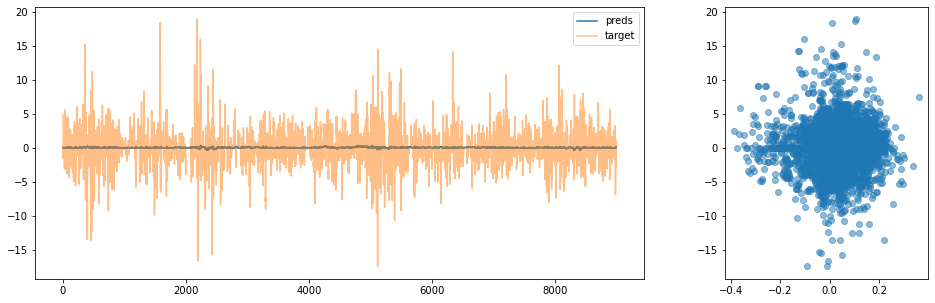

In [251]:
plot_results(df_plot_val)

corr:  -0.15985389513506182
r2:  -0.02036100670474217


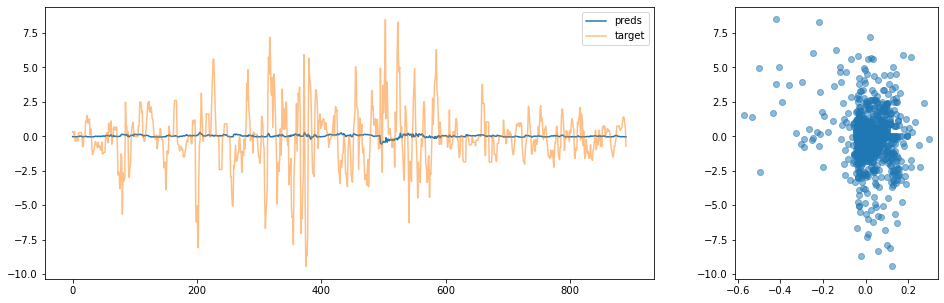

In [252]:
plot_results(df_plot_val_unseen)

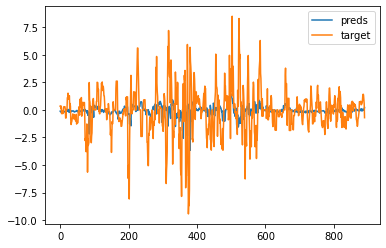

In [114]:
plt.plot(model.predict(df_validation_unseen_norm, columns_features, cpu_dev), label="preds")
plt.plot(df_validation_unseen_norm.reset_index()[columns_target],label= "target")
plt.legend()